### Instalar pacotes

Este código precisa de algumas bibliotecas para rodar.<br>
Abaixo estão os comando para sua instalação:

In [1]:
!pip install bitstring

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Código Auxiliar

In [2]:
import pickle
import numpy as np

from itertools import product
from bitstring import BitArray, Bits, BitStream

In [3]:
class MyImgFormat:
    def __init__(self, mat_rgb_ids, rgb_ids_dict):
        self.im_shape_      = mat_rgb_ids.shape
        self.rgb_ids_dict_  = rgb_ids_dict
        self.num_bits_uint_ = int(np.ceil(np.log2(len(rgb_ids_dict))))
        
        self._mat2bytes(mat_rgb_ids)
        
    def _mat2bytes(self, mat):
        self.pixel_bytes_ = BitStream()
        
        pixel_rgb_ids = mat.reshape(-1)
        for rgb_id in pixel_rgb_ids:
            self.pixel_bytes_.append(Bits(uint=int(rgb_id), length=self.num_bits_uint_))
        
    def unpack(self):
        # unpack IDs
        cp_bits = self.pixel_bytes_.copy()
        num_ids = cp_bits.len // self.num_bits_uint_
        
        mat_ids = np.array([
            cp_bits.read('uint:%d' % (self.num_bits_uint_))\
            for i in range(num_ids)\
        ]).reshape(self.im_shape_)
        
        # unpack RGB
        im_rgb = np.zeros((self.im_shape_[0], self.im_shape_[1], 3), dtype='uint8')
        for i in range(self.im_shape_[0]):
            for j in range(self.im_shape_[1]):
                im_rgb[i, j, :] = self.rgb_ids_dict_[mat_ids[i, j]]
                
        return im_rgb

In [4]:
def uniform_quant(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch
    
    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))
    
    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size)
    
    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}
    
    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]
    
    return mat_ids, dict_id2pixel

In [5]:
def get_bin_size_kb(obj):
    return len(pickle.dumps(obj)) / 1e3

In [6]:
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt


#1)

###A)
A função original recebe o n_colors e com ele determina o número de tons para cada canal de cor (Red, Green, Blue), onde a partir desse número é determinado o espaço/intervalo entre os tons, e os valores utilizados por ela, que na função original, serão sempre os valores mínimos para cada intervalo. Por exemplo, se n_colors = 64, teremos apenas 4 tons de cores para cada canal e o bin_size será de 64, logo os intervalos serão de 0 a 63, 64 a 127, 128 a 191, 192 a 255, entçao os valores utilizados serão:   

    ch_vals: [0, 64, 128, 192]

Como queremos modificar a função para que os valores de RGB sejam o meio
do intervalo quantizado, deveremos ter, para 64 cores, os seguintes valores:
    
    ch_vals: [32, 96, 160, 224]

Para isso basta obter a metade do bin_size e somar ao cálculo do ch_vals e do im_qt_rgb da seguinte forma:

    ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size + bin_size_medio)
    im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size + bin_size_medio)


In [7]:
def uniform_quant_modificada(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch
  
    # como queremos o valor médio, então vamos usar o bin_size médio
    bin_size_medio = bin_size // 2

    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size + bin_size_medio)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))
    
    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size + bin_size_medio)
    
    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}
    
    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]
    
    return mat_ids, dict_id2pixel

## B)

## Imagem Original

In [8]:
img = load_sample_image('china.jpg')

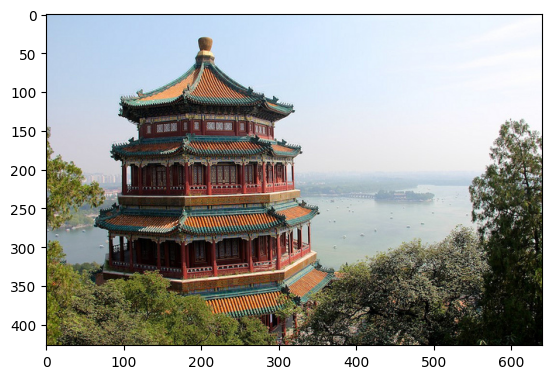

(427, 640, 3)


In [9]:
plt.imshow(img)
plt.show()
print(img.shape)

In [10]:
#verificando o número de intensidade de tons tem na imagem
np.unique(img) 

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

Como podemos ver a imagem original possui 256 valores de tons para cada pixel na imagem. Isso significa que existem 256 X 256 X 256 = 16.777.216 cores na imagem

## Imagem Quantizada para 64 cores
### - Resultado usando o código original

In [11]:
#Quantizando a imagem para 64 cores usando o codigo original
mat_id_original, dict_original = uniform_quant(img, 64)

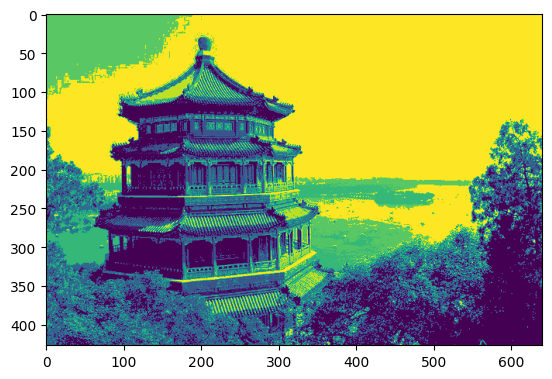

In [12]:
plt.imshow(mat_id_original)
plt.show()

In [13]:
img_quant_original = MyImgFormat(mat_id_original, dict_original)

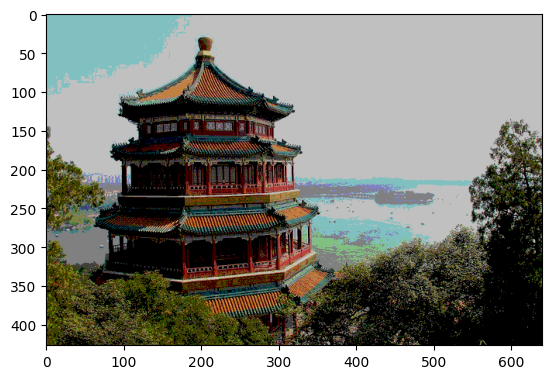

In [14]:
# reconstruindo a imagem para realizar o plot 
img_quant_original_unpacked = img_quant_original.unpack()
plt.imshow(img_quant_original_unpacked)

In [15]:
np.unique(img_quant_original_unpacked) # verficando quantas intensidades de tons nossa imagem quantizada tem (deve ter 4)

array([  0,  64, 128, 192], dtype=uint8)

Como podemos ver a quantização funcionou, temos apenas 4 valores de tons para cada pixel na imagem [0, 64, 128, 192], então há apenas 4 valores únicos em cada canal de cor. Isso significa que existem 4 x 4 x 4 = 64 cores na imagem

In [16]:
print(dict_original) #todas as cores da nossa imagem quantizada

{0: [0, 0, 0], 1: [0, 0, 64], 2: [0, 0, 128], 3: [0, 0, 192], 4: [0, 64, 0], 5: [0, 64, 64], 6: [0, 64, 128], 7: [0, 64, 192], 8: [0, 128, 0], 9: [0, 128, 64], 10: [0, 128, 128], 11: [0, 128, 192], 12: [0, 192, 0], 13: [0, 192, 64], 14: [0, 192, 128], 15: [0, 192, 192], 16: [64, 0, 0], 17: [64, 0, 64], 18: [64, 0, 128], 19: [64, 0, 192], 20: [64, 64, 0], 21: [64, 64, 64], 22: [64, 64, 128], 23: [64, 64, 192], 24: [64, 128, 0], 25: [64, 128, 64], 26: [64, 128, 128], 27: [64, 128, 192], 28: [64, 192, 0], 29: [64, 192, 64], 30: [64, 192, 128], 31: [64, 192, 192], 32: [128, 0, 0], 33: [128, 0, 64], 34: [128, 0, 128], 35: [128, 0, 192], 36: [128, 64, 0], 37: [128, 64, 64], 38: [128, 64, 128], 39: [128, 64, 192], 40: [128, 128, 0], 41: [128, 128, 64], 42: [128, 128, 128], 43: [128, 128, 192], 44: [128, 192, 0], 45: [128, 192, 64], 46: [128, 192, 128], 47: [128, 192, 192], 48: [192, 0, 0], 49: [192, 0, 64], 50: [192, 0, 128], 51: [192, 0, 192], 52: [192, 64, 0], 53: [192, 64, 64], 54: [192, 6

### - Resultado usando o código modificado

In [17]:
#Quantizando a imagem para 64 cores usando o codigo feito no item A)
mat_id_mod, dict_mod = uniform_quant_modificada(img, 64)

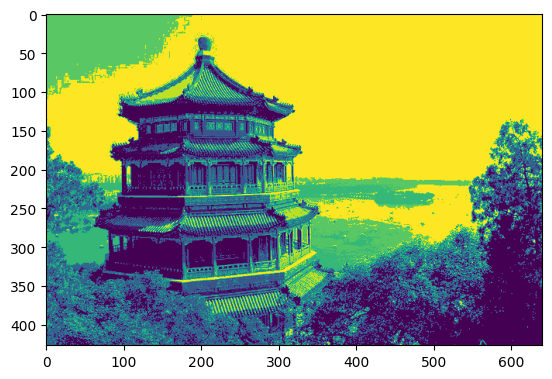

In [18]:
plt.imshow(mat_id_mod)
plt.show()

In [19]:
img_quant_mod = MyImgFormat(mat_id_mod, dict_mod)

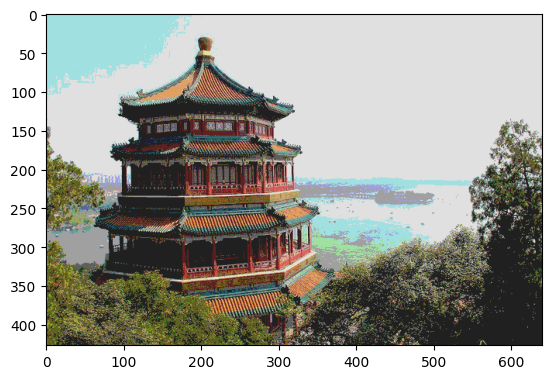

In [20]:
# reconstruindo a imagem para realizar o plot 
img_quant_mod_unpacked = img_quant_mod.unpack()
plt.imshow(img_quant_mod_unpacked)

In [21]:
np.unique(img_quant_mod_unpacked) # verificando quantas intensidades de tons a nossa imagem quantizada tem (deve ter 4)

array([ 32,  96, 160, 224], dtype=uint8)

Como podemos ver a quantização funcionou, temos apenas 4 valores de tons para cada pixel na imagem [32, 96, 160, 224], então há apenas 4 valores únicos em cada canal de cor. Isso significa que existem 4 x 4 x 4 = 64 cores na imagem

In [22]:
print(dict_mod) # todas as cores da nossa imagem quatizada utilizando os valores do meio do intervalo

{0: [32, 32, 32], 1: [32, 32, 96], 2: [32, 32, 160], 3: [32, 32, 224], 4: [32, 96, 32], 5: [32, 96, 96], 6: [32, 96, 160], 7: [32, 96, 224], 8: [32, 160, 32], 9: [32, 160, 96], 10: [32, 160, 160], 11: [32, 160, 224], 12: [32, 224, 32], 13: [32, 224, 96], 14: [32, 224, 160], 15: [32, 224, 224], 16: [96, 32, 32], 17: [96, 32, 96], 18: [96, 32, 160], 19: [96, 32, 224], 20: [96, 96, 32], 21: [96, 96, 96], 22: [96, 96, 160], 23: [96, 96, 224], 24: [96, 160, 32], 25: [96, 160, 96], 26: [96, 160, 160], 27: [96, 160, 224], 28: [96, 224, 32], 29: [96, 224, 96], 30: [96, 224, 160], 31: [96, 224, 224], 32: [160, 32, 32], 33: [160, 32, 96], 34: [160, 32, 160], 35: [160, 32, 224], 36: [160, 96, 32], 37: [160, 96, 96], 38: [160, 96, 160], 39: [160, 96, 224], 40: [160, 160, 32], 41: [160, 160, 96], 42: [160, 160, 160], 43: [160, 160, 224], 44: [160, 224, 32], 45: [160, 224, 96], 46: [160, 224, 160], 47: [160, 224, 224], 48: [224, 32, 32], 49: [224, 32, 96], 50: [224, 32, 160], 51: [224, 32, 224], 52:

Como podemos ver a função utilizando os valores de RGB que sejam o meio
do intervalo quantizado produz uma imagem mais clara, isso já era esperado pois quanto mais alto o valor dos tons de cada canal mais clara será a cor produzida. 

## C)

In [23]:
#imagem original:
print(f'Tamanho da imagem original: {get_bin_size_kb(img)}KB')

Tamanho da imagem original: 820.005KB


In [24]:
#imagem quantizada com a funcao original:
print(f'Tamanho da imagem quantizada para 64 cores usando o código original: {get_bin_size_kb(img_quant_original)}KB')


Tamanho da imagem quantizada para 64 cores usando o código original: 206.207KB


In [25]:
#imagem quantizada com a funcao feita no item A):
print(f'Tamanho da imagem quantizada para 64 cores usando o código feito no item anterior: {get_bin_size_kb(img_quant_mod)}KB')


Tamanho da imagem quantizada para 64 cores usando o código feito no item anterior: 206.207KB


Como podemos ver a imagem original é maior que as imagens quantizadas, isso ocorre pois a imagem orginal possui 256 valores de tonalidades para cada canal, exigindo 8 bits para cada canal de cor, ou seja, 24 bits por pixel, representando 16.777.216 cores. Já as imagens quantizadas, como vimos no item anterior, possui apenas 4 valores de tonalidades para cada canal, exigindo apenas 2 bits para cada canal de cor, ou seja, 6 bits por pixel, representando 64 cores.

OBS: As duas imagens quantizadas possuem o mesmo tamanho pois elas foram submetidas ao mesmo processo de quantização, a unica diferença é a tonalidade das cores, o que não influencia no tamanho da imagem.

## 2)

### A)

In [26]:
from sklearn.cluster import KMeans

In [27]:
def MyKmeans(imagem, n_clusters, max_iter, random_state):
  # vamos transformar nossa imagem em uma tabela para usar o kmeans
  X = imagem.reshape((-1, 3))

  kmeans = KMeans(
    # n_clusters = representa o numero de cores
    n_clusters= n_clusters,
    max_iter= max_iter,
    random_state= random_state
  )

  kmeans.fit(X)

  # retorna o cluster ao qual cada elemento pertence, ou seja, o rgb do primeiro pixel pertence ao cluster que começa esse array do predict e assim por diante
  mat_id = kmeans.predict(X) 
    
  # armazenando cada valor rgb de cada cluster
  rgb_clusters = kmeans.cluster_centers_

  # 3) A)
  inercia = kmeans.inertia_

  mat_id = mat_id.reshape((img.shape[0], img.shape[1]))

  return mat_id, rgb_clusters, inercia

### B)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


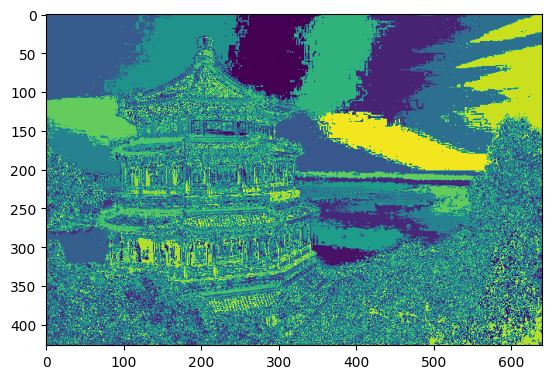

In [28]:
mat_id_clusters, rgb_clusters, inercia = MyKmeans(img, 64, 10, 42)

plt.imshow(mat_id_clusters)


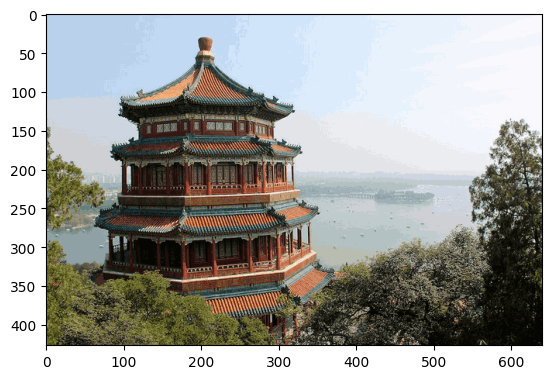

In [29]:
img_quant_kmeans = MyImgFormat(mat_id_clusters, rgb_clusters)
unpacked_kmeans = img_quant_kmeans.unpack()
plt.imshow(unpacked_kmeans)

Plotando as imagens da questão anterior para comparação

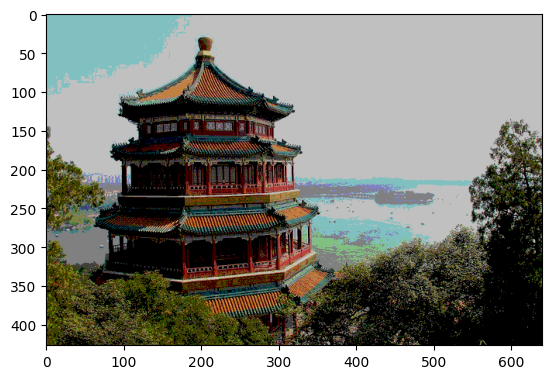

In [30]:
plt.imshow(img_quant_original_unpacked)

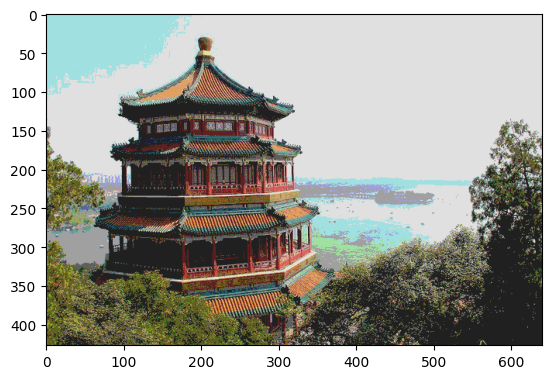

In [31]:
plt.imshow(img_quant_mod_unpacked)

### Conclusão:
Como podemos ver a imagem quantizada com kmeans possui muito mais detalhe do que as imagens quantizadas uniformemente, na imagem feita por kmeans é possível notar o degradê no céu, o mar fica muito mais realista e a torre fica mais nítida. Isso ocorre pois o kmeans consegue separar os pixels em vários grupos de forma que ele distribuiu melhor as cores conseguindo entregar bem mais detalhes usando 64 possibilidades de cores.

## 3)

### A)

Adicionando a função kmeans.inertia_ na função criada na 2)A)

In [32]:
print(inercia)

30958883.95753027


### B)

In [33]:
from sklearn.metrics import mean_squared_error

def calcula_mse(img_original, img_quant):

  # Verifica se as dimensões das imagens são iguais
  if img_original.shape != img_quant.shape:
    raise ValueError("As dimensões das imagens são diferentes.")

  # Calcula o MSE entre as imagens
  mse = mean_squared_error(img_original.astype(np.float64).flatten(), img_quant.astype(np.float64).flatten()) #o flatten eh usado para deixar a imagem em uma dimensão
  
  
  return mse


In [34]:
print(f'MSE: {calcula_mse(img, unpacked_kmeans)}')

MSE: 38.110081235363


O MSE (Mean Squared Error ou Erro Médio Quadrático) é uma métrica usada para avaliar a diferença entre duas imagens. Ele mede a média da diferença dos valores de pixel ao quadrado entre duas imagens, ou seja, a diferença entre a intensidade de cada pixel em cada imagem, elevada ao quadrado, e então calcula a média desses valores para toda a imagem.
Como foi observado o MSE entre as duas imagens foi de 38, um número relativamente baixo, então podemos concluir que as imagens são bem parecidas, mesmo com uma grande redução de cores.

## 4)

In [35]:
img_flower = load_sample_image('flower.jpg')

### A) Quantização das imagens

8 cores:

In [36]:
num_cores = 8
#uniforme
mat_id, dict_id2pixel = uniform_quant(img, num_cores)

#kmeans
mat_id_clusters, rgb_clusters, inercia = MyKmeans(img, num_cores, 10, 42)

img_quant_uniforme = MyImgFormat(mat_id, dict_id2pixel)
img_quant_kmeans = MyImgFormat(mat_id_clusters, rgb_clusters)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


8 cores:

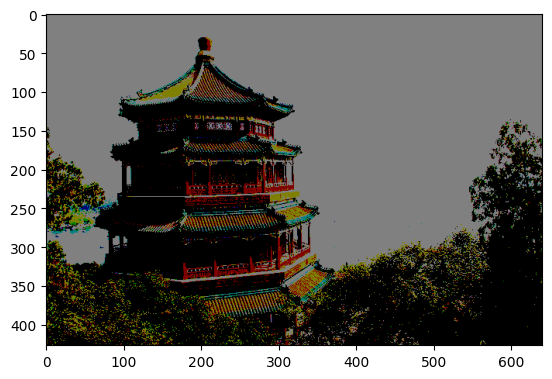

In [37]:
# reconstruindo a imagem para realizar o plot 
img_quant_uniforme_unpacked = img_quant_uniforme.unpack()
plt.imshow(img_quant_uniforme_unpacked)

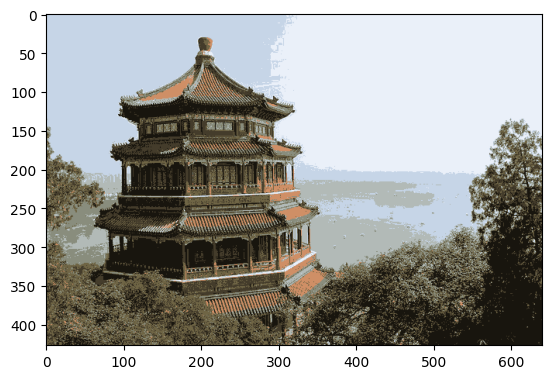

In [38]:

unpacked_kmeans = img_quant_kmeans.unpack()
plt.imshow(unpacked_kmeans)

Calculos para os itens B) C) D)

In [39]:
mse_china_uniforme = []
mse_china_kmeans = []

In [40]:
mse_china_uniforme.append(calcula_mse(img, img_quant_uniforme_unpacked))
mse_china_kmeans.append(calcula_mse(img, unpacked_kmeans))

In [41]:
tam_china_original = []
tam_china_uniforme = []
tam_china_kmeans = []

In [42]:
tam_china_original.append(get_bin_size_kb(img))
tam_china_uniforme.append(get_bin_size_kb(img_quant_uniforme))
tam_china_kmeans.append(get_bin_size_kb(img_quant_kmeans))

In [43]:
inercia_china = []

In [44]:
inercia_china.append(inercia)

27 cores:

In [45]:
num_cores = 27
#uniforme
mat_id, dict_id2pixel = uniform_quant(img, num_cores)

#kmeans
mat_id_clusters, rgb_clusters, inercia = MyKmeans(img, num_cores, 10, 42)

img_quant_uniforme = MyImgFormat(mat_id, dict_id2pixel)
img_quant_kmeans = MyImgFormat(mat_id_clusters, rgb_clusters)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


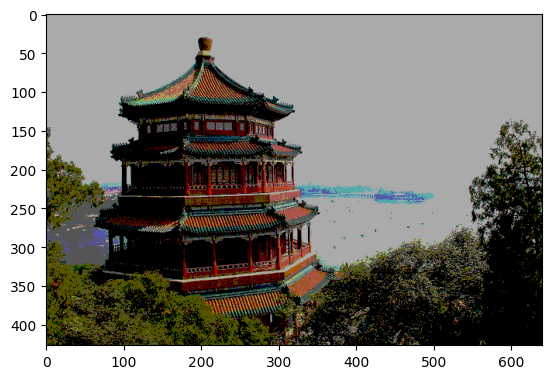

In [46]:
# reconstruindo a imagem para realizar o plot 
img_quant_uniforme_unpacked = img_quant_uniforme.unpack()
plt.imshow(img_quant_uniforme_unpacked)

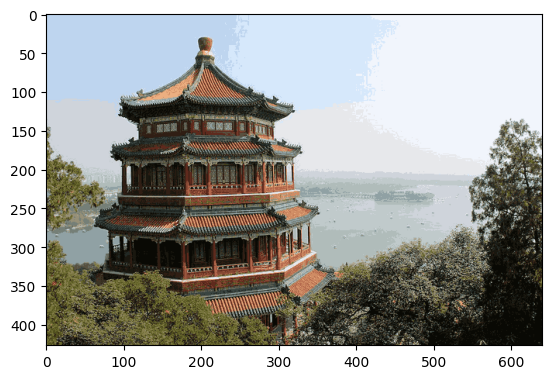

In [47]:
unpacked_kmeans = img_quant_kmeans.unpack()
plt.imshow(unpacked_kmeans)

In [48]:
mse_china_uniforme.append(calcula_mse(img, img_quant_uniforme_unpacked))
mse_china_kmeans.append(calcula_mse(img, unpacked_kmeans))

In [49]:
tam_china_original.append(get_bin_size_kb(img))
tam_china_uniforme.append(get_bin_size_kb(img_quant_uniforme))
tam_china_kmeans.append(get_bin_size_kb(img_quant_kmeans))

In [50]:
inercia_china.append(inercia)

64 cores:

In [51]:
num_cores = 64
#uniforme
mat_id, dict_id2pixel = uniform_quant(img, num_cores)

#kmeans
mat_id_clusters, rgb_clusters, inercia = MyKmeans(img, num_cores, 10, 42)

img_quant_uniforme = MyImgFormat(mat_id, dict_id2pixel)
img_quant_kmeans = MyImgFormat(mat_id_clusters, rgb_clusters)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


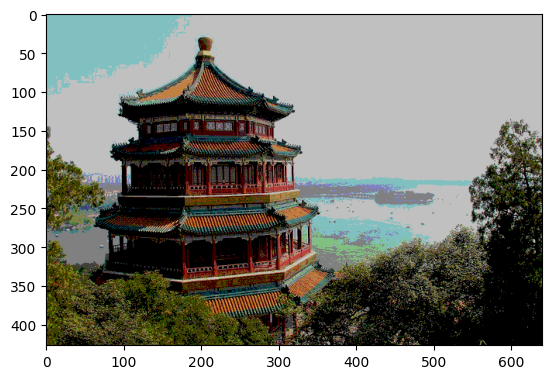

In [52]:
# reconstruindo a imagem para realizar o plot 
img_quant_uniforme_unpacked = img_quant_uniforme.unpack()
plt.imshow(img_quant_uniforme_unpacked)

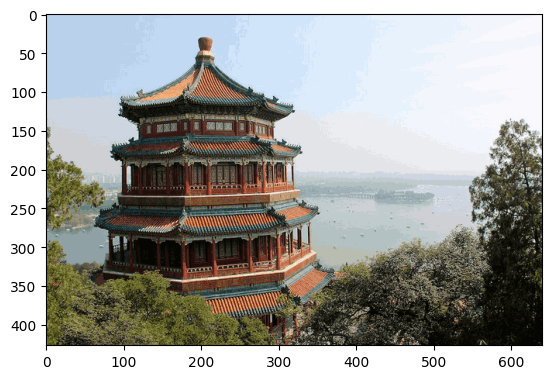

In [53]:
unpacked_kmeans = img_quant_kmeans.unpack()
plt.imshow(unpacked_kmeans)

In [54]:
mse_china_uniforme.append(calcula_mse(img, img_quant_uniforme_unpacked))
mse_china_kmeans.append(calcula_mse(img, unpacked_kmeans))

In [55]:
tam_china_original.append(get_bin_size_kb(img))
tam_china_uniforme.append(get_bin_size_kb(img_quant_uniforme))
tam_china_kmeans.append(get_bin_size_kb(img_quant_kmeans))

In [56]:
inercia_china.append(inercia)

125 cores:

In [57]:
num_cores = 125
#uniforme
mat_id, dict_id2pixel = uniform_quant(img, num_cores)

#kmeans
mat_id_clusters, rgb_clusters, inercia = MyKmeans(img, num_cores, 10, 42)

img_quant_uniforme = MyImgFormat(mat_id, dict_id2pixel)
img_quant_kmeans = MyImgFormat(mat_id_clusters, rgb_clusters)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


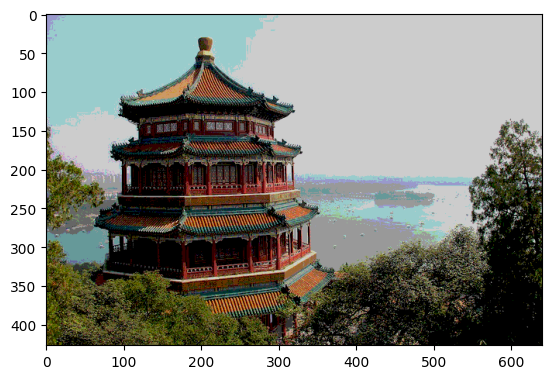

In [58]:
# reconstruindo a imagem para realizar o plot 
img_quant_uniforme_unpacked = img_quant_uniforme.unpack()
plt.imshow(img_quant_uniforme_unpacked)

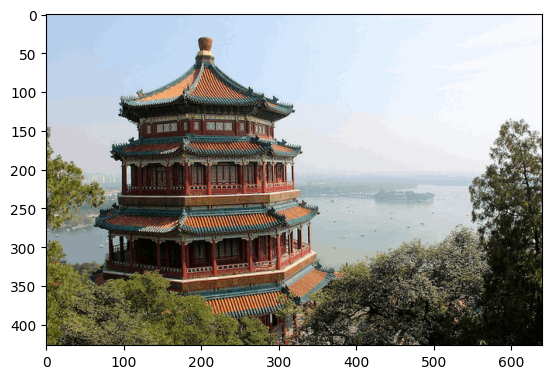

In [59]:
unpacked_kmeans = img_quant_kmeans.unpack()
plt.imshow(unpacked_kmeans)

In [60]:
mse_china_uniforme.append(calcula_mse(img, img_quant_uniforme_unpacked))
mse_china_kmeans.append(calcula_mse(img, unpacked_kmeans))

In [61]:
tam_china_original.append(get_bin_size_kb(img))
tam_china_uniforme.append(get_bin_size_kb(img_quant_uniforme))
tam_china_kmeans.append(get_bin_size_kb(img_quant_kmeans))

In [62]:
inercia_china.append(inercia)

216 cores:

In [63]:
num_cores = 216
#uniforme
mat_id, dict_id2pixel = uniform_quant(img, num_cores)

#kmeans
mat_id_clusters, rgb_clusters, inercia = MyKmeans(img, num_cores, 10, 42)

img_quant_uniforme = MyImgFormat(mat_id, dict_id2pixel)
img_quant_kmeans = MyImgFormat(mat_id_clusters, rgb_clusters)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


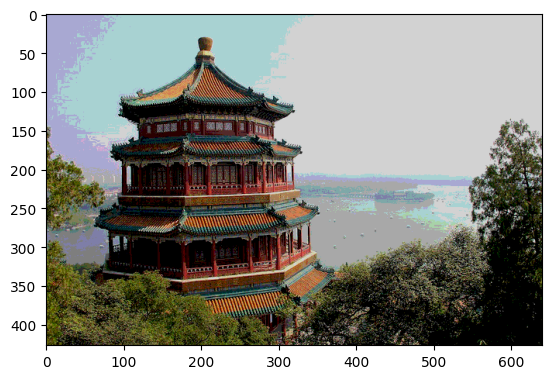

In [64]:
# reconstruindo a imagem para realizar o plot 
img_quant_uniforme_unpacked = img_quant_uniforme.unpack()
plt.imshow(img_quant_uniforme_unpacked)

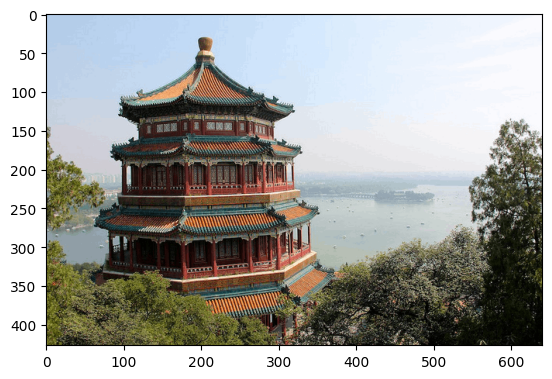

In [65]:
unpacked_kmeans = img_quant_kmeans.unpack()
plt.imshow(unpacked_kmeans)

In [66]:
mse_china_uniforme.append(calcula_mse(img, img_quant_uniforme_unpacked))
mse_china_kmeans.append(calcula_mse(img, unpacked_kmeans))

In [67]:
tam_china_original.append(get_bin_size_kb(img))
tam_china_uniforme.append(get_bin_size_kb(img_quant_uniforme))
tam_china_kmeans.append(get_bin_size_kb(img_quant_kmeans))

In [68]:
inercia_china.append(inercia)

Para a flower.jpg

8 cores:

In [69]:
num_cores = 8
#uniforme
mat_id, dict_id2pixel = uniform_quant(img_flower, num_cores)

#kmeans
mat_id_clusters, rgb_clusters, inercia = MyKmeans(img_flower, num_cores, 10, 42)

img_quant_uniforme = MyImgFormat(mat_id, dict_id2pixel)
img_quant_kmeans = MyImgFormat(mat_id_clusters, rgb_clusters)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


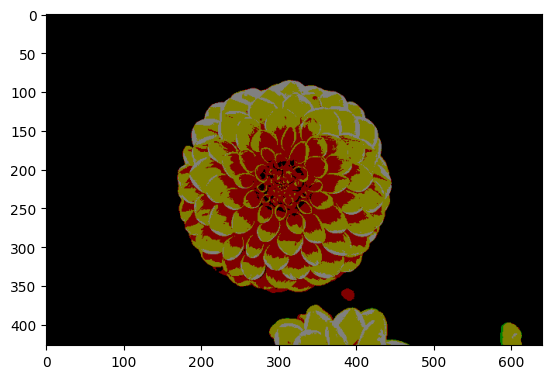

In [70]:
# reconstruindo a imagem para realizar o plot 
img_quant_uniforme_unpacked = img_quant_uniforme.unpack()
plt.imshow(img_quant_uniforme_unpacked)

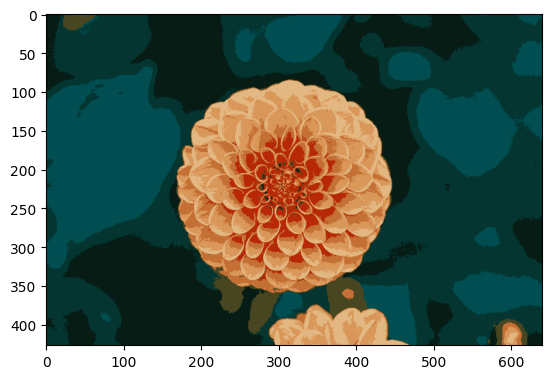

In [71]:
unpacked_kmeans = img_quant_kmeans.unpack()
plt.imshow(unpacked_kmeans)

Claculo para os itens B) C) D):

In [72]:
mse_flower_uniforme = []
mse_flower_kmeans = []

In [73]:
mse_flower_uniforme.append(calcula_mse(img_flower, img_quant_uniforme_unpacked))
mse_flower_kmeans.append(calcula_mse(img_flower, unpacked_kmeans))

In [74]:
tam_flower_original = []
tam_flower_uniforme = []
tam_flower_kmeans = []

In [75]:
tam_flower_original.append(get_bin_size_kb(img))
tam_flower_uniforme.append(get_bin_size_kb(img_quant_uniforme))
tam_flower_kmeans.append(get_bin_size_kb(img_quant_kmeans))

In [76]:
inercia_flower = []

In [77]:
inercia_flower.append(inercia)

27 cores:

In [78]:
num_cores = 27
#uniforme
mat_id, dict_id2pixel = uniform_quant(img_flower, num_cores)

#kmeans
mat_id_clusters, rgb_clusters, inercia = MyKmeans(img_flower, num_cores, 10, 42)

img_quant_uniforme = MyImgFormat(mat_id, dict_id2pixel)
img_quant_kmeans = MyImgFormat(mat_id_clusters, rgb_clusters)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


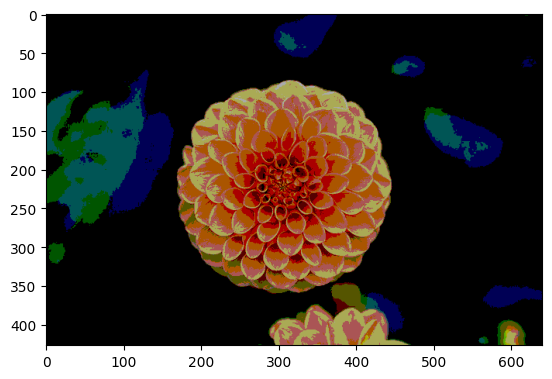

In [79]:
# reconstruindo a imagem para realizar o plot 
img_quant_uniforme_unpacked = img_quant_uniforme.unpack()
plt.imshow(img_quant_uniforme_unpacked)

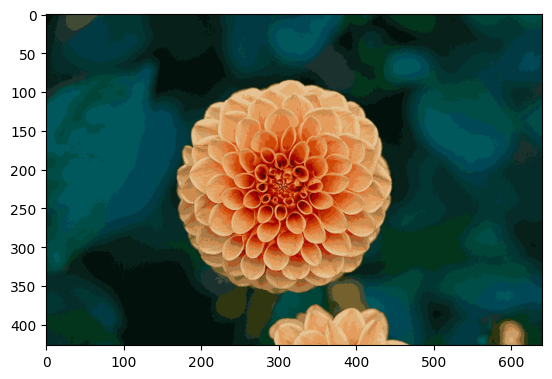

In [80]:
unpacked_kmeans = img_quant_kmeans.unpack()
plt.imshow(unpacked_kmeans)

In [81]:
mse_flower_uniforme.append(calcula_mse(img_flower, img_quant_uniforme_unpacked))
mse_flower_kmeans.append(calcula_mse(img_flower, unpacked_kmeans))

In [82]:
tam_flower_original.append(get_bin_size_kb(img))
tam_flower_uniforme.append(get_bin_size_kb(img_quant_uniforme))
tam_flower_kmeans.append(get_bin_size_kb(img_quant_kmeans))

In [83]:
inercia_flower.append(inercia)

64 cores:

In [84]:
num_cores = 64
#uniforme
mat_id, dict_id2pixel = uniform_quant(img_flower, num_cores)

#kmeans
mat_id_clusters, rgb_clusters, inercia = MyKmeans(img_flower, num_cores, 10, 42)

img_quant_uniforme = MyImgFormat(mat_id, dict_id2pixel)
img_quant_kmeans = MyImgFormat(mat_id_clusters, rgb_clusters)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


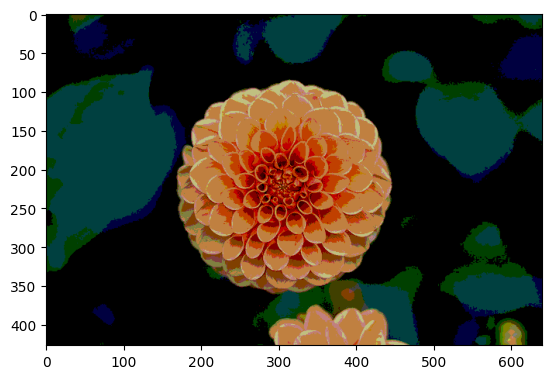

In [85]:
# reconstruindo a imagem para realizar o plot 
img_quant_uniforme_unpacked = img_quant_uniforme.unpack()
plt.imshow(img_quant_uniforme_unpacked)

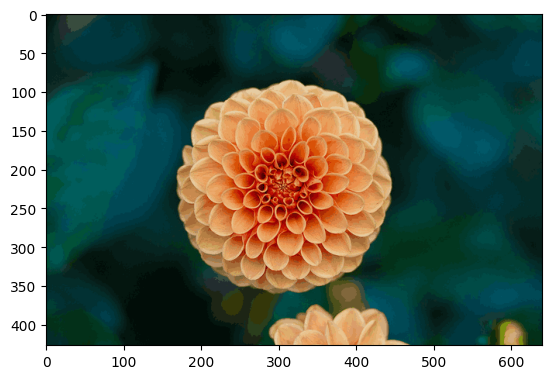

In [86]:
unpacked_kmeans = img_quant_kmeans.unpack()
plt.imshow(unpacked_kmeans)

In [87]:
mse_flower_uniforme.append(calcula_mse(img_flower, img_quant_uniforme_unpacked))
mse_flower_kmeans.append(calcula_mse(img_flower, unpacked_kmeans))

In [88]:
tam_flower_original.append(get_bin_size_kb(img))
tam_flower_uniforme.append(get_bin_size_kb(img_quant_uniforme))
tam_flower_kmeans.append(get_bin_size_kb(img_quant_kmeans))

In [89]:
inercia_flower.append(inercia)

127 cores:

In [90]:
num_cores = 127
#uniforme
mat_id, dict_id2pixel = uniform_quant(img_flower, num_cores)

#kmeans
mat_id_clusters, rgb_clusters, inercia = MyKmeans(img_flower, num_cores, 10, 42)

img_quant_uniforme = MyImgFormat(mat_id, dict_id2pixel)
img_quant_kmeans = MyImgFormat(mat_id_clusters, rgb_clusters)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


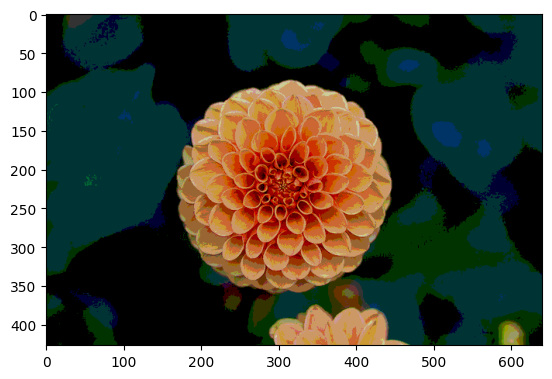

In [91]:
# reconstruindo a imagem para realizar o plot 
img_quant_uniforme_unpacked = img_quant_uniforme.unpack()
plt.imshow(img_quant_uniforme_unpacked)

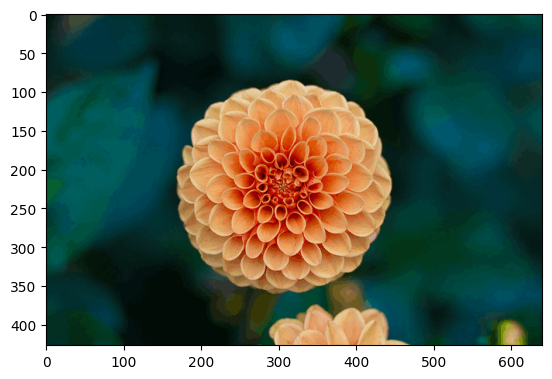

In [92]:
unpacked_kmeans = img_quant_kmeans.unpack()
plt.imshow(unpacked_kmeans)

In [93]:
mse_flower_uniforme.append(calcula_mse(img_flower, img_quant_uniforme_unpacked))
mse_flower_kmeans.append(calcula_mse(img_flower, unpacked_kmeans))

In [94]:
tam_flower_original.append(get_bin_size_kb(img))
tam_flower_uniforme.append(get_bin_size_kb(img_quant_uniforme))
tam_flower_kmeans.append(get_bin_size_kb(img_quant_kmeans))

In [95]:
inercia_flower.append(inercia)

256 cores:

In [96]:
num_cores = 127
#uniforme
mat_id, dict_id2pixel = uniform_quant(img_flower, num_cores)

#kmeans
mat_id_clusters, rgb_clusters, inercia = MyKmeans(img_flower, num_cores, 10, 42)

img_quant_uniforme = MyImgFormat(mat_id, dict_id2pixel)
img_quant_kmeans = MyImgFormat(mat_id_clusters, rgb_clusters)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


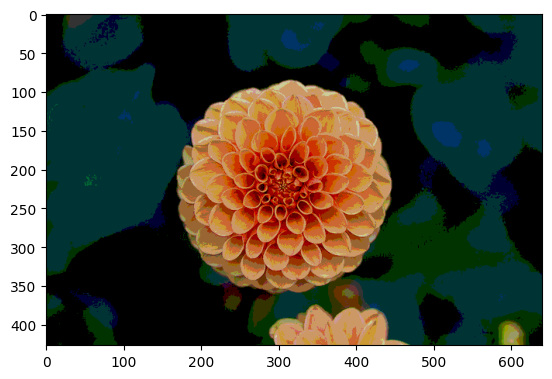

In [97]:
# reconstruindo a imagem para realizar o plot 
img_quant_uniforme_unpacked = img_quant_uniforme.unpack()
plt.imshow(img_quant_uniforme_unpacked)

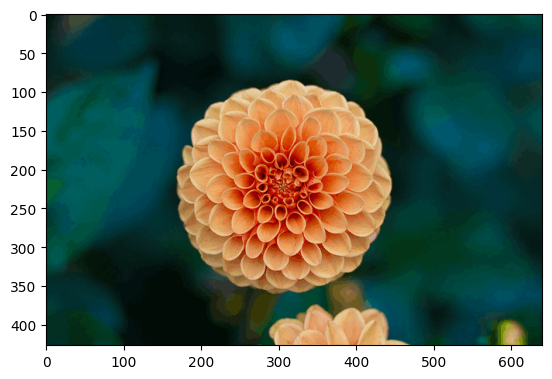

In [98]:
unpacked_kmeans = img_quant_kmeans.unpack()
plt.imshow(unpacked_kmeans)

In [99]:
mse_flower_uniforme.append(calcula_mse(img_flower, img_quant_uniforme_unpacked))
mse_flower_kmeans.append(calcula_mse(img_flower, unpacked_kmeans))

In [100]:
tam_flower_original.append(get_bin_size_kb(img))
tam_flower_uniforme.append(get_bin_size_kb(img_quant_uniforme))
tam_flower_kmeans.append(get_bin_size_kb(img_quant_kmeans))

In [101]:
inercia_flower.append(inercia)

### B) Plotando a inércia

valores: [174483375.236687, 60629832.80199637, 30958883.95753027, 19335990.86861003, 13284058.995163541]


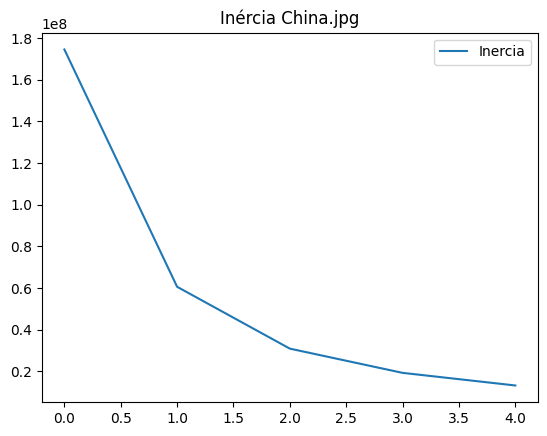

valores: [118670601.12771297, 39579000.24639112, 20482708.80371024, 12471134.664087769, 12471134.664087769]


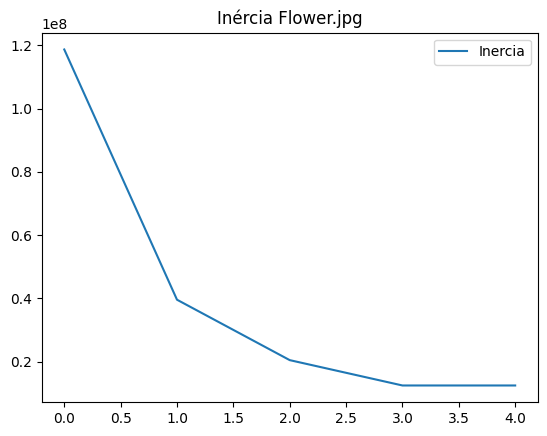

In [102]:
# criando o eixo x
x = np.arange(len(inercia_china))

# Criando o gráfico de linhas
plt.plot(x, inercia_china, label='Inercia')
print(f'valores: {inercia_china}')
plt.title("Inércia China.jpg")
plt.legend()
plt.show()

# criando o eixo x
x = np.arange(len(inercia_flower))

# Criando o gráfico de linhas
plt.plot(x, inercia_flower, label='Inercia')
print(f'valores: {inercia_flower}')
plt.title("Inércia Flower.jpg")
plt.legend()
plt.show()

### C) Plotando o MSE

valores: [6709.022199453552, 2732.7196074843873, 1506.2420277127244, 958.8115973848555, 691.6209797033567]
valores: [212.93527395589382, 74.27944354996097, 38.110081235363, 23.9639612607338, 16.521377341920374]


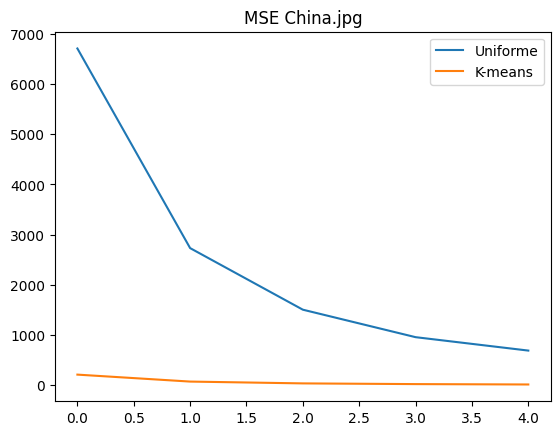

In [103]:
# criando o eixo x
x = np.arange(len(mse_china_uniforme))

# Criando o gráfico de linhas
plt.plot(x, mse_china_uniforme, label='Uniforme')
plt.plot(x, mse_china_kmeans, label='K-means')
print(f'valores: {mse_china_uniforme}')
print(f'valores: {mse_china_kmeans}')
plt.title('MSE China.jpg')
plt.legend()
plt.show()

valores: [3084.977011368072, 1798.7539422326308, 993.5048802205308, 625.3515856752537, 625.3515856752537]
valores: [145.05326039227165, 48.62556840359095, 25.3284018832943, 15.573632660031226, 15.573632660031226]


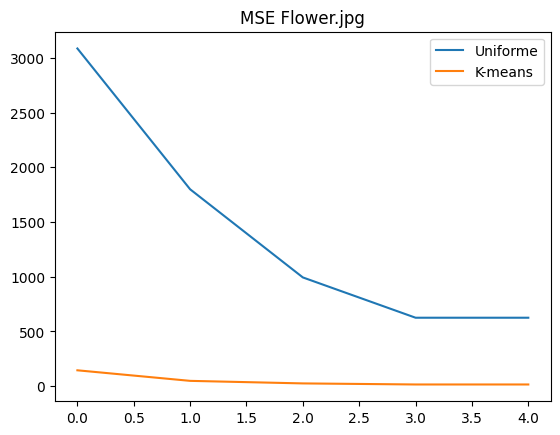

In [104]:
# criando o eixo x
x = np.arange(len(mse_flower_uniforme))

# Criando o gráfico de linhas
plt.plot(x, mse_flower_uniforme, label='Uniforme')
plt.plot(x, mse_flower_kmeans, label='K-means')
print(f'valores: {mse_flower_uniforme}')
print(f'valores: {mse_flower_kmeans}')
plt.title('MSE Flower.jpg')
plt.legend()
plt.show()

### D) Plotando o tamanho das imagens

valores: [820.005, 820.005, 820.005, 820.005, 820.005]
valores: [103.003, 171.577, 206.207, 241.125, 276.406]
valores: [103.095, 171.874, 206.922, 242.546, 278.89]


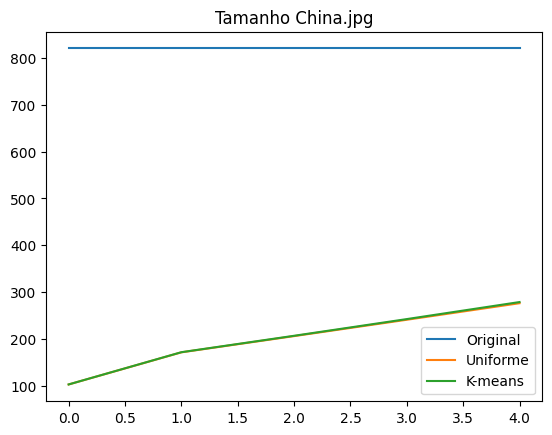

In [105]:
# criando o eixo x
x = np.arange(len(tam_china_original))

# Criando o gráfico de linhas
plt.plot(x, tam_china_original, label='Original')
plt.plot(x, tam_china_uniforme, label='Uniforme')
plt.plot(x, tam_china_kmeans, label='K-means')
print(f'valores: {tam_china_original}')
print(f'valores: {tam_china_uniforme}')
print(f'valores: {tam_china_kmeans}')

plt.title('Tamanho China.jpg')
plt.legend()
plt.show()

valores: [820.005, 820.005, 820.005, 820.005, 820.005]
valores: [103.003, 171.577, 206.207, 241.125, 241.125]
valores: [103.095, 171.874, 206.922, 242.594, 242.594]


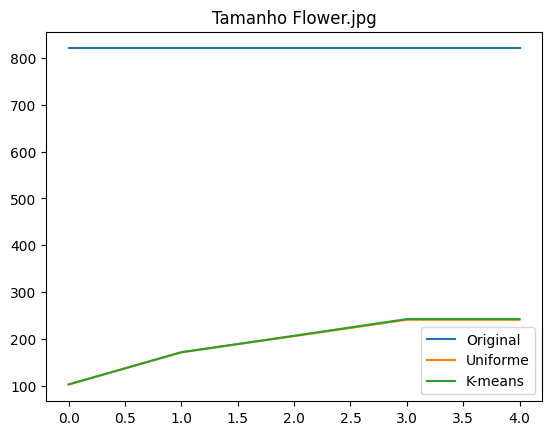

In [106]:
# criando o eixo x
x = np.arange(len(tam_flower_original))

# Criando o gráfico de linhas
plt.plot(x, tam_flower_original, label='Original')
plt.plot(x, tam_flower_uniforme, label='Uniforme')
plt.plot(x, tam_flower_kmeans, label='K-means')
print(f'valores: {tam_flower_original}')
print(f'valores: {tam_flower_uniforme}')
print(f'valores: {tam_flower_kmeans}')

plt.title('Tamanho Flower.jpg')
plt.legend()
plt.show()

### Conclusão da 4:
Como podemos notar, visualmente, no item A) o desempenho da quantização usando kmeans é sempre superior ao da uniforme, nos itens B) e C) a diferença visual se comprova, visto que no item B) o valor da inércia diminui conforme aumentamos a quantidade de cores, ou seja, tivemos uma clusterização melhor, pois isso indica que os pontos dentro de cada cluster estão mais próximos do seu centróide e, portanto, mais similares entre si. E no item C) Podemos notar que até o MSE da imagens com menos cores do kmeans é mais baixo que o MSE da imagem com mais cores da quantização uniforme.
No item D) podemos ver que o tamanho das imagens quantizadas são praticamente os mesmos, independente do tipo de quantização feita, mostrando que podemos ter uma imagem muito bonita, quase igual a original, mas muito mais leve.